<a href="https://colab.research.google.com/github/thayeylolu/cyberbullying/blob/main/notebooks/pytorch_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS 

In [ ]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.1 MB/s 
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [ ]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import os 

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


### Basic Parameters

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def encode_label(label):
    if label == 'not_cyberbullying':
        return 0
    elif label == 'gender':
        return 1
    elif label == 'religion':
        return 2
    elif label == 'other_cyberbullying':
        return 3
    elif label == 'age':
        return 4
    else:
      return 5

In [ ]:
url = "/content/drive/MyDrive/NLP/train_data.csv"
#url = "train_data.csv"

In [ ]:
df = pd.read_csv(url)
df = df.dropna()
df['label_name'] = df['cyberbullying_type'].apply(encode_label)
df = df[['label_name', 'clean_txt_emoji']]

train, test_valid = train_test_split(df,train_size= 0.70, random_state= 3040)
test, valid = train_test_split(test_valid,train_size= .50, random_state= 3040)
test['label_name'].value_counts()

train_X, train_y = train['clean_txt_emoji'].to_list(), train['label_name'].to_list()
test_X, test_y = test['clean_txt_emoji'].to_list(), test['label_name'].to_list()
valid_X, valid_y = valid['clean_txt_emoji'].to_list(), valid['label_name'].to_list()

train_dat =list(zip(train_y,train_X))
valid_dat =list(zip(valid_y,valid_X))
test_dat=list(zip(test_y,test_X))

In [ ]:
df.sample(3)

,label_name,clean_txt_emoji
1682,0,ash camilla people choice dish great MKR
11008,1,feminazi nice word inherently misogynist
14927,1,kat fkn ass MKR


In [ ]:
df

,label_name,clean_txt_emoji
0,0,words food crapilicious katandandre mkr
1,0,white aussietv MKR theblock ImACelebrityAU tod...
2,0,classy whore red velvet cupcakes
3,0,meh thanks heads concerned another angry dude ...
4,0,isis account pretending kurdish account like i...
...,...,...
47687,5,black ppl expected anything depended anything ...
47688,5,turner withhold disappointment turner called c...
47689,5,swear god dumb nigger bitch got bleach hair re...
47690,5,yea fuck youre nigger fucking unfollow fucking...


In [ ]:
# Field is a normal column 
# LabelField is the label column.
from torchtext.legacy import data

TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [ ]:
fields = [("label_name",LABEL),('clean_txt_emoji',TEXT)]

In [ ]:
training_data = data.TabularDataset(path=url,
                                    format="csv",
                                    fields=fields,
                                    skip_header=True
                                   )

print(vars(training_data.examples[4]))

{'label_name': '4', 'clean_txt_emoji': ['isis', 'account', 'pretending', 'kurdish', 'account', 'like', 'islam', 'lies']}


## Finding the maxlen

In [ ]:
# import pandas as pd
# import numpy as np

# measurer = np.vectorize(len)

# res2 = measurer(data.select_dtypes(include=[object]).values.astype(str)).max(axis=0)

In [ ]:
# data['len'] = data['clean_txt_emoji'].apply(lambda s : len(s))

In [ ]:
# data['len'].plot.hist(bins=100)

In [ ]:
# data.len.quantile(0.9)

## Preprocessing Y Column
We are only going to be classifying conditions for which the count of label_names are more than 3000.

In [ ]:
df.sample(6)

,label_name,clean_txt_emoji
4746,0,say time blog nearly enough liking
30260,3,nooooooooooo instant resturants away MKR
43795,5,fucking dumb saying people deserve cancer hate...
11842,1,bred dangerous feminazi country
38748,4,focus big one know one teaching boys bully wom...
177,0,jfc


In [ ]:
import plotly.express as px
import re

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

In [ ]:
le.classes_

array([0, 1, 2, 3, 4, 5])

### Load Embeddings


In [ ]:
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip glove*.zip
# !ls
# !pwd

# import zipfile
# with zipfile.ZipFile('glove.840B.300d.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/NLP/')

In [ ]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/NLP/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
np.shape(embedding_matrix)

(33749, 300)

## Pytorch Model - TextCNN

In [ ]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

## Train TextCNN Model

In [ ]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/6 	 loss=394.6497 	 val_loss=246.1152  	 val_acc=0.8026  	 time=16.23s
Epoch 2/6 	 loss=229.3038 	 val_loss=217.7863  	 val_acc=0.8261  	 time=16.70s
Epoch 3/6 	 loss=201.5630 	 val_loss=208.1309  	 val_acc=0.8263  	 time=17.61s
Epoch 4/6 	 loss=186.7376 	 val_loss=203.7169  	 val_acc=0.8345  	 time=18.26s
Epoch 5/6 	 loss=174.1670 	 val_loss=202.4927  	 val_acc=0.8327  	 time=17.96s
Epoch 6/6 	 loss=163.8784 	 val_loss=198.8607  	 val_acc=0.8355  	 time=17.34s


In [ ]:
torch.save(model,'textcnn_model')

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

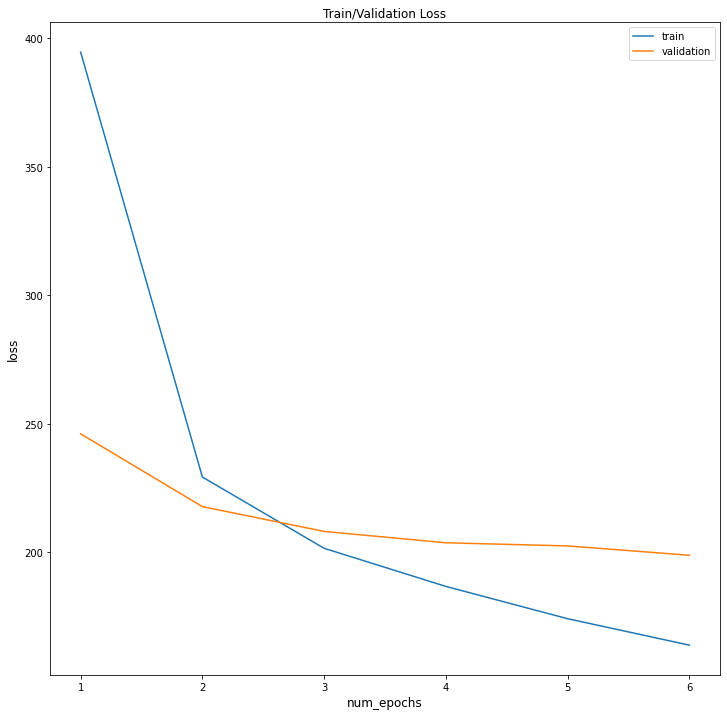

In [ ]:
plot_graph(n_epochs)

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


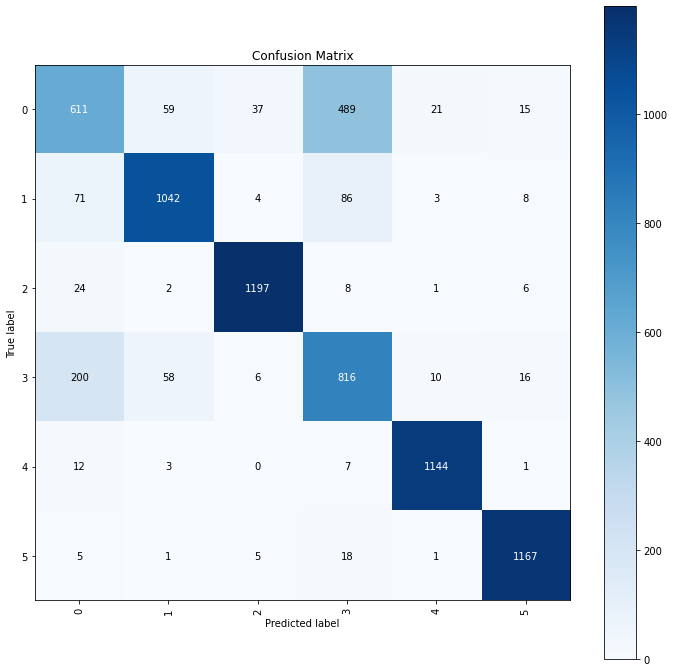

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Pytorch Model - BiLSTM

In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/6 	 loss=596.1454 	 val_loss=279.8803  	 val_acc=0.7886  	 time=15.95s
Epoch 2/6 	 loss=250.8460 	 val_loss=226.8749  	 val_acc=0.8148  	 time=15.71s
Epoch 3/6 	 loss=214.7111 	 val_loss=210.6591  	 val_acc=0.8247  	 time=15.45s
Epoch 4/6 	 loss=198.7405 	 val_loss=206.2970  	 val_acc=0.8265  	 time=15.28s
Epoch 5/6 	 loss=188.0662 	 val_loss=205.2708  	 val_acc=0.8299  	 time=15.06s
Epoch 6/6 	 loss=177.8364 	 val_loss=199.2759  	 val_acc=0.8356  	 time=15.30s


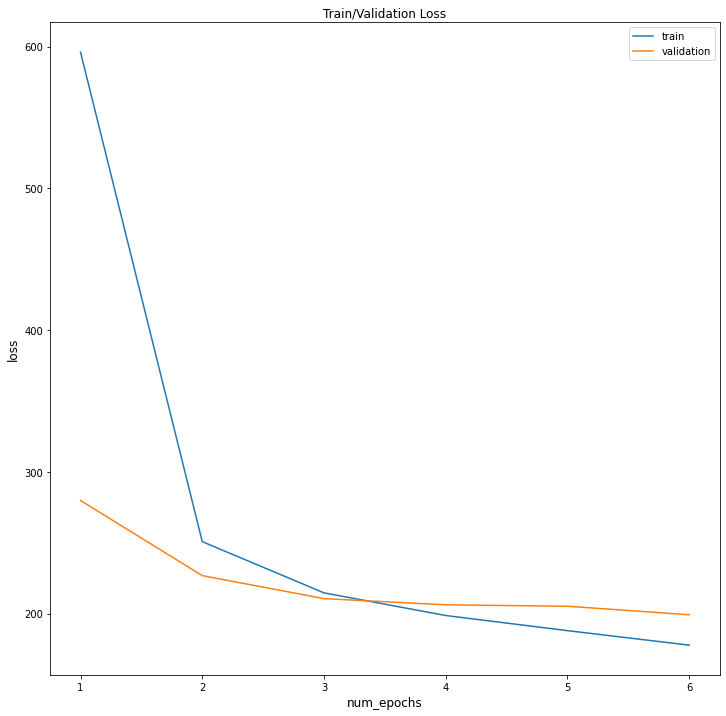

In [ ]:
plot_graph(n_epochs)

In [ ]:
torch.save(model,'bilstm_model')

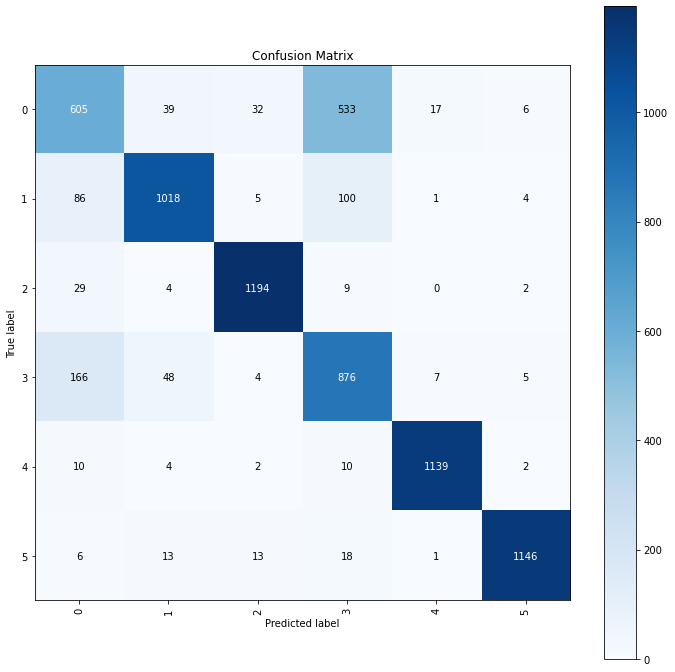

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Deploy : Predict A Single Example

In [ ]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [ ]:
x = df['clean_txt_emoji'].values[20]
print(x)

know saudis chased girls burning building 


In [ ]:
predict_single(x)

NameError: ignored